In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

%matplotlib inline

In [2]:
!pip install arch

     |████████████████████████████████| 875 kB 5.0 MB/s 
     |████████████████████████████████| 9.5 MB 36.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
!pip3 install yfinance

     |████████████████████████████████| 6.3 MB 7.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=cd5d89f1f1c1b7f7f9721a356eae4080580ad4fa09dcf58db7a18f64488647fa
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
import yfinance as yf

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
from datetime import datetime, timedelta
from sklearn.metrics import (mean_squared_error as mse)

In [8]:
tickers = ['aapl', 'amzn', 'cl=f', 'tsla', 'btc-usd', 'dis', 'msft']

start = datetime(2010, 1, 1)
end = datetime.today()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


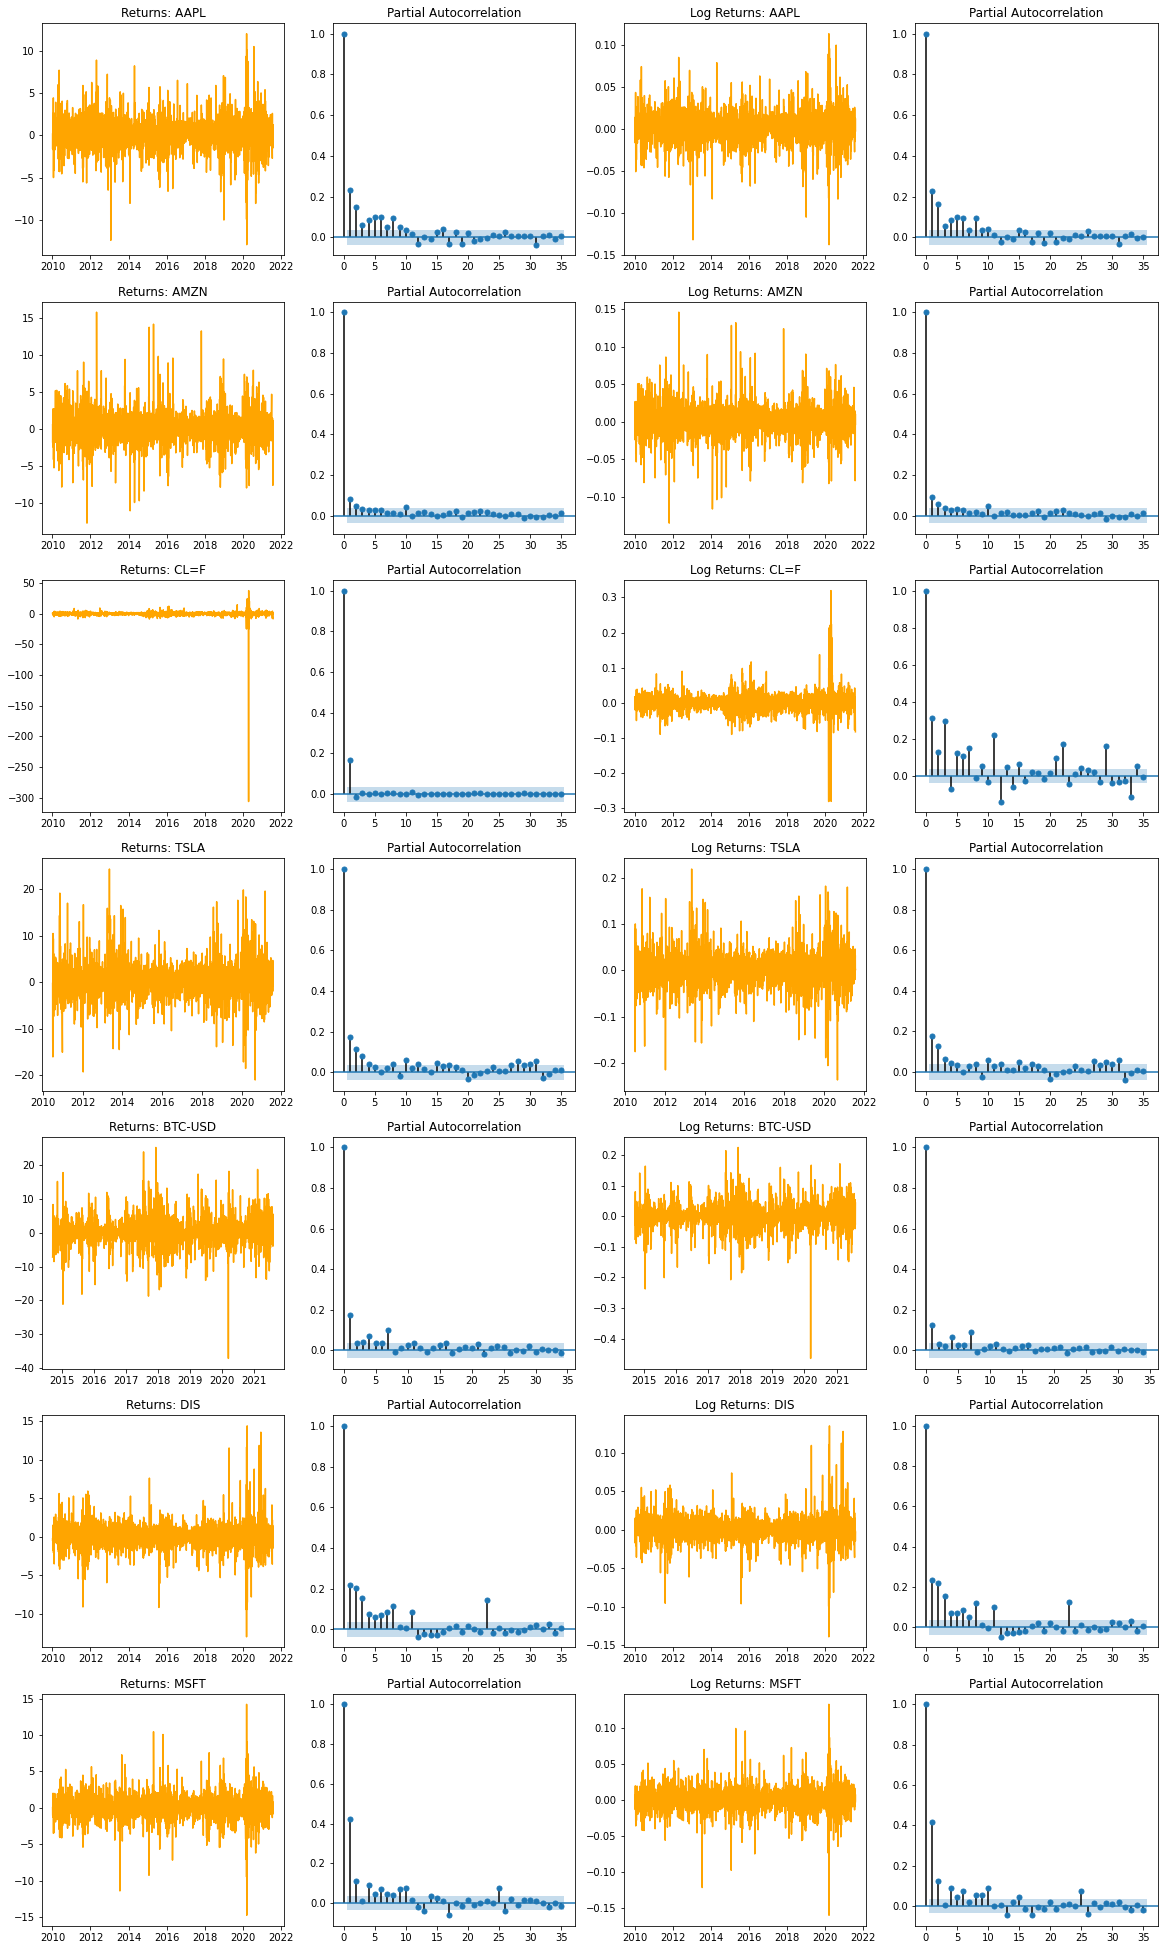

In [9]:
fig, axes = plt.subplots(nrows=len(tickers), ncols=4, figsize=(20,len(tickers)*5))

for i, ticker in enumerate(tickers):
    tckr = yf.Ticker(ticker)
    historical = tckr.history(start=start, 
                              end=end, 
                              interval="1d")
    # Returns
    returns = 100 * historical.Close.pct_change().dropna()

    axes[i][0].plot(returns, color='orange')
    axes[i][0].set_title(f'Returns: {ticker.upper()}')

    plot_pacf(returns**2, ax=axes[i][1])

    # Log Returns
    log_returns = np.log(historical.Close/historical.Close.shift(1)).dropna()

    axes[i][2].plot(log_returns, color='orange')
    axes[i][2].set_title(f'Log Returns: {ticker.upper()}')

    plot_pacf(log_returns**2, ax=axes[i][3])

plt.show();

## BTC-USD

In [11]:
start = datetime(2014, 1, 1)
end = datetime.today()

tckr = 'BTC-USD'

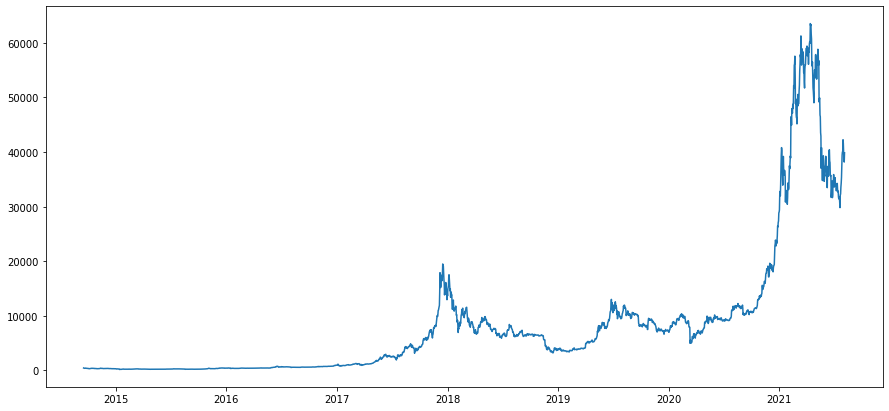

In [12]:
ticker = yf.Ticker(tckr)
ticker_historical = ticker.history(start=start, 
                                   end=end, 
                                   interval="1d")

plt.figure(figsize=(15,7))
plt.plot(ticker_historical.Close);

In [13]:
ticker_historical.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0


Getting the price returns in this case would give us a more stationary time series.

Also, volatility is often calculated as the standard deviation of price returns.

In [14]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
returns = 100 * ticker_historical.Close.pct_change().dropna()

Further research seems to indicate that for practicality purposes it's quite common to use the log returns as well because it helps eliminate non-stationary properties of time series data, and makes it more stable. On top of that, it reduces computational cost. 


LOG RETURNS FORMULA:

$r_{t} = log(P_{t} / P_{t-1})$

In [15]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
log_returns = np.log(ticker_historical.Close/ticker_historical.Close.shift(1)).dropna()

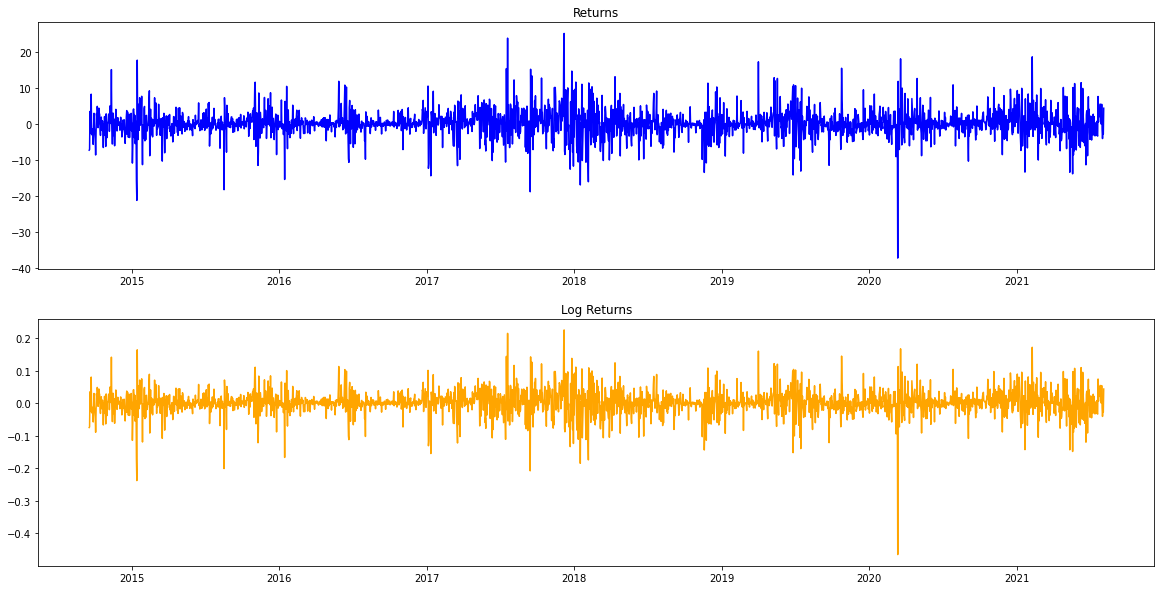

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

ax1.plot(returns, color='blue')
ax1.set_title('Returns')

ax2.plot(log_returns, color='orange')
ax2.set_title('Log Returns')

fig.show();

The daily returns & log returns look centered over the x-axis with no trend over time.

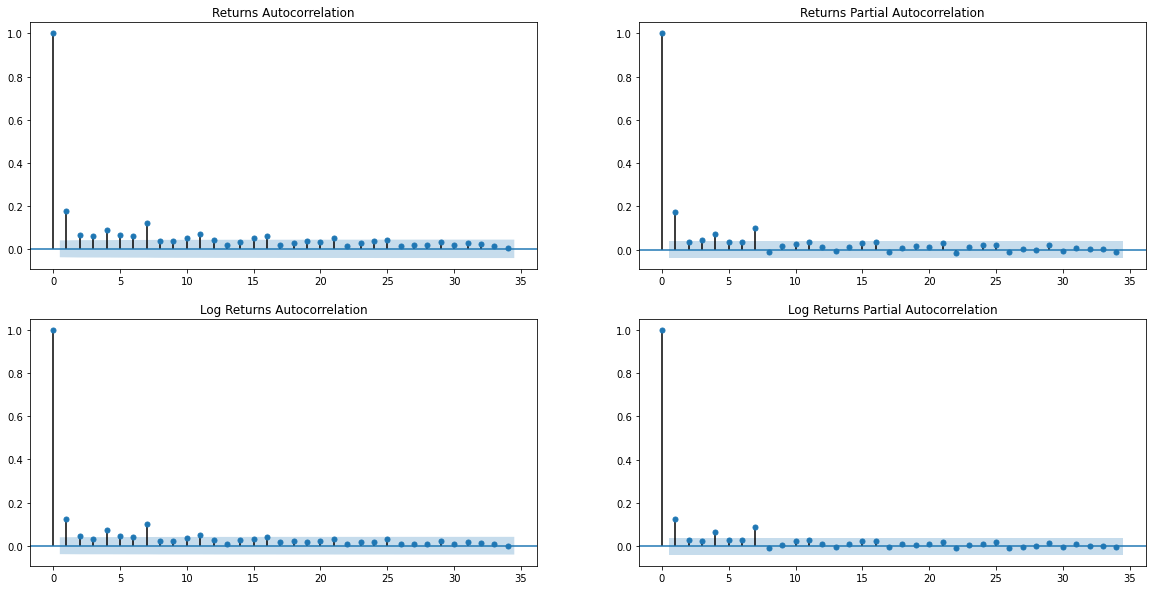

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

plot_acf(returns**2, ax=axes[0][0])
plot_pacf(returns**2, ax=axes[0][1])
axes[0][0].set_title('Returns Autocorrelation')
axes[0][1].set_title('Returns Partial Autocorrelation')

plot_acf(log_returns**2, ax=axes[1][0])
plot_pacf(log_returns**2, ax=axes[1][1])
axes[1][0].set_title('Log Returns Autocorrelation')
axes[1][1].set_title('Log Returns Partial Autocorrelation')

fig.show();

In [18]:
returns.describe()

count    2509.000000
mean        0.255929
std         3.922924
min       -37.169539
25%        -1.275418
50%         0.200057
75%         1.821009
max        25.247169
Name: Close, dtype: float64

In [19]:
log_returns.describe()

count    2509.000000
mean        0.001781
std         0.039574
min        -0.464730
25%        -0.012836
50%         0.001999
75%         0.018046
max         0.225119
Name: Close, dtype: float64

In [20]:
from scipy import stats

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


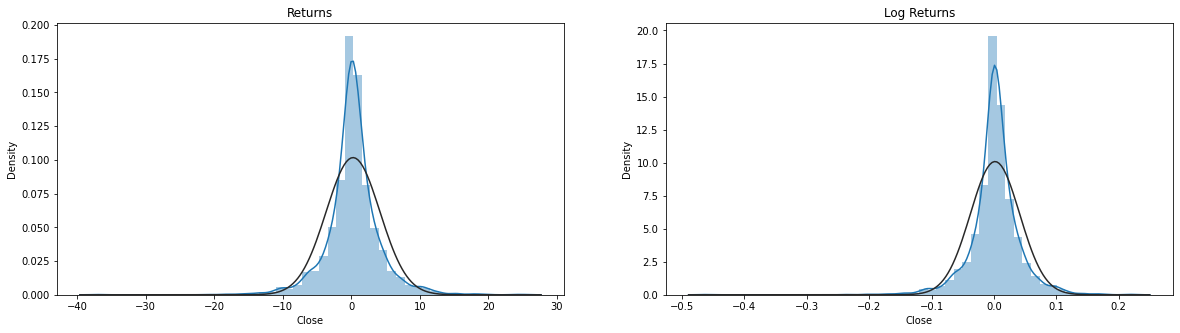

In [21]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.distplot(returns, norm_hist=True, fit=stats.norm, 
             bins=50, ax=ax1)
ax1.set_title('Returns')

sns.distplot(log_returns, norm_hist=True, fit=stats.norm, 
             bins=50, ax=ax2)
ax2.set_title('Log Returns')

fig.show();

Both Returns & Log Returns show some:
- slight negative skewness
- positive kurtosis (leptokurtic) - higher peak with thick tails than the standard normal distribution.

Volatility is often calculated as the standard deviation or variance of price returns. 

The higher the returns, the riskier the asset.

Basically the idea here is to describe the volatility (standard deviation/variance) of a variable (returns/log returns of close price of BTC-USD) on day `t` as estimated at the end of the previous day t-1.

Based on this definition, it seems like there're probably multiple ways that volatility can be calculated:
1. Using the accumulative moving average of ALL previous values
2. Using rolling average of a specified look-back window (for example, if `WINDOW_SIZE = 5` then Volatility at time step `t` would be calculated using the moving average of previous 30 time steps' returns (from time step `t-5` to time step `t-1`).

In [22]:
# CREATE A FUNCTION TO ESTIMATE HISTORICAL VOLATILITY
def get_volatility(ts, window=None):
    """
    Get the volatility of a time series as the standard deviation of an index's
    price returns using cumulative moving average or rolling window average
    depending on whether or not window parameter is specified
    """
    if window:
        ma = ts.rolling(window).mean()
    else:
        ma = ts.expanding().mean()
    output = ((ts - ma)**2)**.5

    return output

### Stationarity Checking

In [23]:
from statsmodels.tsa.stattools import adfuller

In [24]:
adfuller_results = adfuller(returns)

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -15.017485235881809
p-value: 1.0339066264043701e-27
Critical Values:
1%: -3.4330
5%: -2.8627
10%: -2.5674


Using a significant level alpha of 0.05, p-value is significantly smaller than alpha, which means I can reject the Null Hypothesis here. 

--> Volatility is not dependent on time/trend

### Train-Validation-Test Split

I would apply the 80/20 rule: 
- train on 80% of the dataset
- and validate using the remaining 20%
- 1 week (7 days) out for testing

There're a total of 2507 datapoints in this dataset which covers a period of almost 7 years from September 2014 until today (July 2021). Since cryptocurrencies are not traded on a regulated exchange, the Bitcoin market is open 24/7, 1 year covers a whole 365 trading days instead of 252 days a year like with other stocks and commodities.

In [25]:
(len(returns)-7)*.8

2001.6000000000001

Therefore, I am going to split the data into 3 parts:
- training: from index 0 to 1999 (inclusive)
- validation: from index 2000 to 2500 (inclusive)
- test - the most recent days

In [26]:
split_time_1 = 2000
split_time_2 = 2500

train_idx = returns.index[:split_time_1]
val_idx = returns.index[split_time_1:split_time_2]
test_idx = returns.index[split_time_2:]

In [27]:
returns.index[2000]

Timestamp('2020-03-10 00:00:00')

In [28]:
ts_train = returns[train_idx]
ts_val = returns[val_idx]
ts_test = returns[test_idx]

The value for `WINDOW_SIZE` is only selected arbitrarily and will be adjusted later based on the outcomes of the models.


In [29]:
WINDOW_SIZE = 14

# CALCULATING VOLATILITY ON A 14 DAY PERIOD
vols = get_volatility(returns, window=WINDOW_SIZE)

vol_train = vols[train_idx]
vol_val = vols[val_idx]
vol_test = vols[test_idx]

In [30]:
ma = returns.rolling(WINDOW_SIZE).mean()
ewma = returns.ewm(span=WINDOW_SIZE).mean()

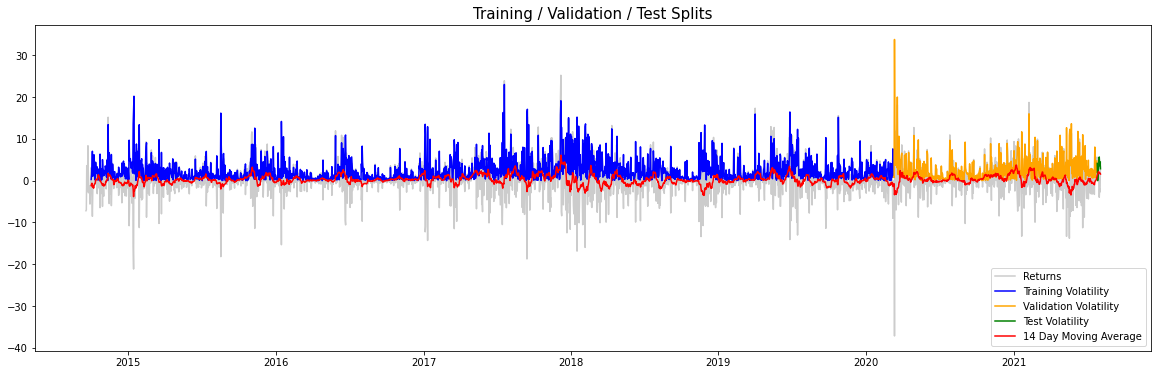

In [33]:
plt.figure(figsize=(20,6))

plt.plot(returns, color='gray', label='Returns', alpha=0.4)
# plt.plot(ts_val, color='gray', label='Validation Returns', alpha=0.4)
# plt.plot(ts_test, color='gray', label='Test Returns', alpha=0.4)

plt.plot(vol_train, color='blue', label='Training Volatility')
plt.plot(vol_val, color='orange', label='Validation Volatility')
plt.plot(vol_test, color='green', label='Test Volatility')

plt.plot(ma, color='red', 
         label=f'{WINDOW_SIZE} Day Moving Average')

plt.plot()
plt.title('Training / Validation / Test Splits', fontsize=15)
plt.legend()
plt.show();

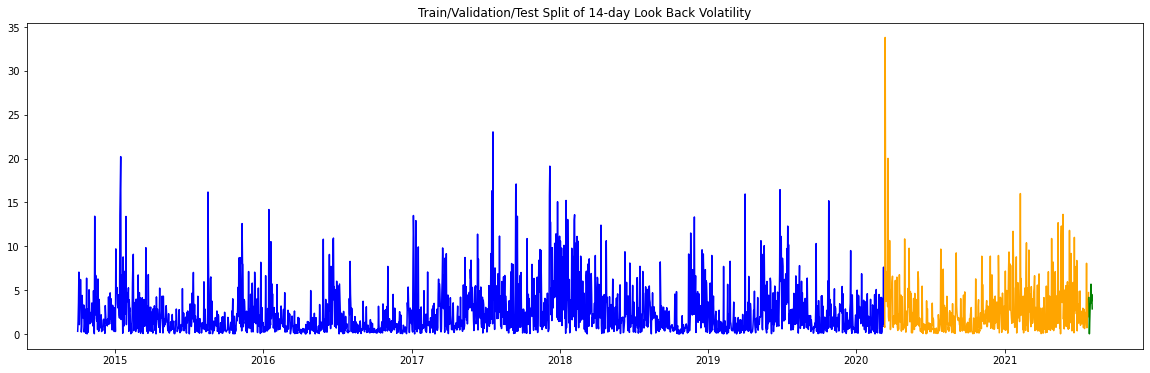

In [34]:
plt.figure(figsize=(20,6))

plt.plot(vol_train, color='blue', label='Training')
plt.plot(vol_val, color='orange', label='Validation')
plt.plot(vol_test, color='green', label='Test')
plt.title(f'Train/Validation/Test Split of {WINDOW_SIZE}-day Look Back Volatility')

plt.show();

Based on the above plot, it looks like volatility is not constant over time, and tend to cluster around large jumps (shocks).

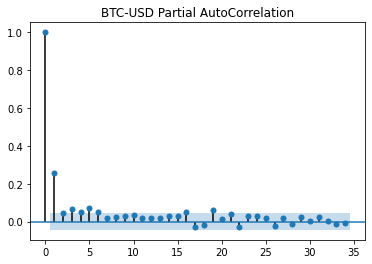

In [35]:
plot_pacf(ts_train**2, 
          title=f'{tckr.upper()} Partial AutoCorrelation');

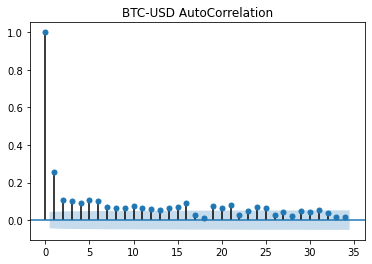

In [36]:
plot_acf(ts_train**2, 
          title=f'{tckr.upper()} AutoCorrelation');

###Baseline model

This would be a very simple model that only outputs the average volatility of the whole training data as predictions.

In [37]:
# CALCULATE THE MEAN OF TRAINING DATA
mean_train_vol = vol_train.mean()
mean_train_vol

2.4140029673991115

In [38]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(ts_val)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=ts_val.index)

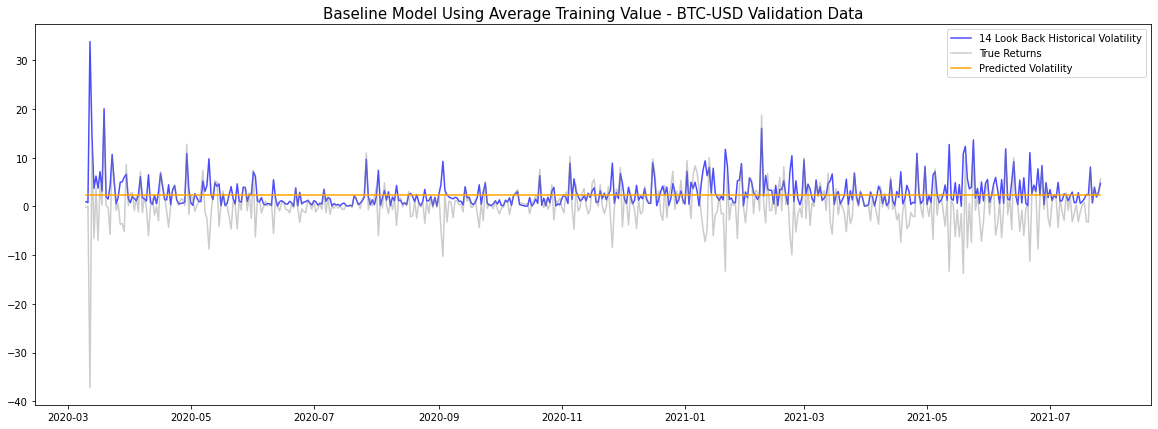

In [39]:
plt.figure(figsize=(20,7))
plt.plot(vol_val, color='blue', label=f'{WINDOW_SIZE} Look Back Historical Volatility', alpha=0.7)
plt.plot(ts_val, color='gray', alpha=0.4, label='True Returns')
plt.plot(baseline_preds, color='orange', label='Predicted Volatility')

plt.title(f'Baseline Model Using Average Training Value - {tckr} Validation Data', fontsize=15)
plt.legend();

In [40]:
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [41]:
RMSE(vol_val, baseline_preds)

3.093908220292956

### Naive Random Walk Forecasting

This is another naive model that uses the exact same volatility at time step `t-1` as prediction for time step `t`.

In [42]:
random_walk_preds = vols.shift(1).dropna()[val_idx]

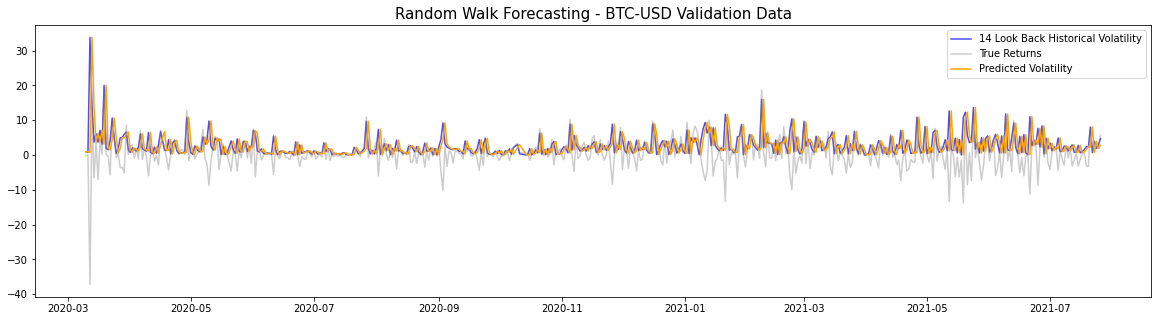

In [43]:
plt.figure(figsize=(20,5))
plt.plot(vol_val, color='blue', alpha=0.7,
         label=f'{WINDOW_SIZE} Look Back Historical Volatility')
plt.plot(ts_val, color='gray', alpha=0.4, label='True Returns')
plt.plot(random_walk_preds, color='orange', label='Predicted Volatility')

plt.title(f'Random Walk Forecasting - {tckr} Validation Data', fontsize=15)
plt.legend();

In [44]:
RMSE(vol_val, random_walk_preds)

4.036131944883187

So far the loss of Baseline model has been lower than Naive Random Walk model. 


### GARCH Model

GARCH Model is the traditional econometric approach to volatility prediction of financial time series.

GARCH(1,1) Model Equation:


$\sigma^2_t = \omega + \alpha\epsilon^{2}_{(t-1)} + \beta\sigma^{2}_{(t-1)}$

All parameters in GARCH are non-negative, therefore the variance cannot be negative. 

I'll eventually try different values of p & q from 1 to 10. But first I'd just experiment with 1 since the Partial Autocorrelation plots seems to indicate that there's only significant correlation between first and second lags, and the ones following don't seem to be significant.

In [45]:
from arch import arch_model

In [46]:
gm_1 = arch_model(ts_train, vol='GARCH', p=1, q=1,
                  mean='constant', dist='normal')

In [47]:
gm_1_fit = gm_1.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5314.497887500565
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5313.817834012814
Iteration:      3,   Func. Count:     22,   Neg. LLF: 5313.2752810261245
Iteration:      4,   Func. Count:     29,   Neg. LLF: 5310.509539218487
Iteration:      5,   Func. Count:     36,   Neg. LLF: 5308.144309823094
Iteration:      6,   Func. Count:     43,   Neg. LLF: 5306.186847417144
Iteration:      7,   Func. Count:     50,   Neg. LLF: 5303.3154907012995
Iteration:      8,   Func. Count:     57,   Neg. LLF: 5303.184300305053
Iteration:      9,   Func. Count:     64,   Neg. LLF: 5302.467794751384
Iteration:     10,   Func. Count:     70,   Neg. LLF: 5302.207079806331
Iteration:     11,   Func. Count:     76,   Neg. LLF: 5302.1143140685635
Iteration:     12,   Func. Count:     82,   Neg. LLF: 5302.110542137104
Iteration:     13,   Func. Count:     88,   Neg. LLF: 5302.110159093707
Iteration:     14,   Func. Count:     94,   Neg. LLF: 5302.11

In [48]:
print(gm_1_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5302.11
Distribution:                  Normal   AIC:                           10612.2
Method:            Maximum Likelihood   BIC:                           10634.6
                                        No. Observations:                 2000
Date:                Wed, Aug 04 2021   Df Residuals:                     1999
Time:                        21:24:24   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1682  6.356e-02      2.647  8.115e-03 [4.368e-0

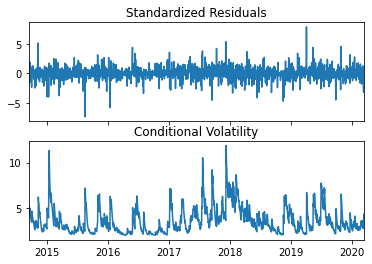

In [49]:
gm_1_fit.plot()
plt.show();

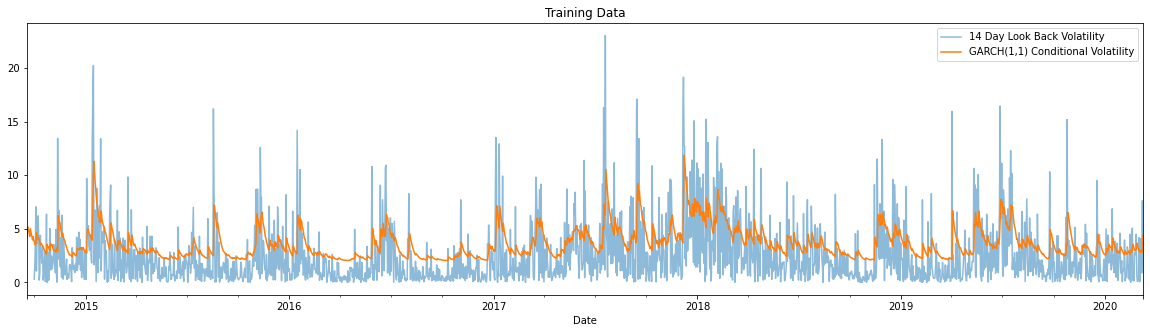

In [51]:
plt.figure(figsize=(20,5))

vol_train.plot(label=f'{WINDOW_SIZE} Day Look Back Volatility', 
               alpha=0.5)

gm_1_fit.conditional_volatility.plot(label='GARCH(1,1) Conditional Volatility')
plt.title('Training Data')
plt.legend();

### Making predictions with basic GARCH(1,1) model

In [52]:
# ROLLING FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    ts_train = returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(ts_train, vol='GARCH', p=1, q=1,
                       mean='constant', dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [53]:
rolling_forecasts[-5:]

[3.7357224602430787,
 3.7593696125065854,
 3.604076520995547,
 3.5516841091060853,
 3.868842220645137]

In [54]:
vol_val.values[-5:]

array([0.71277637, 3.92752609, 1.90910981, 2.80969944, 4.71934291])

In [55]:
rolling_predictions = pd.Series(rolling_forecasts, index=ts_val.index)

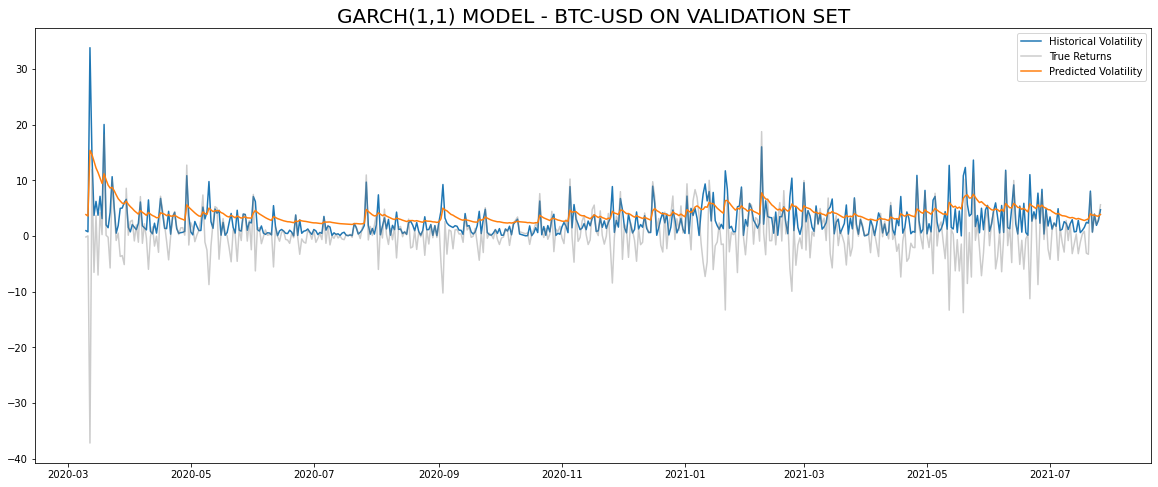

In [56]:
plt.figure(figsize=(20,8))
plt.plot(vol_val, label='Historical Volatility')
plt.plot(ts_val, color='gray', alpha=0.4, label='True Returns')
plt.plot(rolling_predictions, label='Predicted Volatility')

plt.title(f'GARCH(1,1) MODEL - {tckr} ON VALIDATION SET', fontsize=20)
plt.legend();

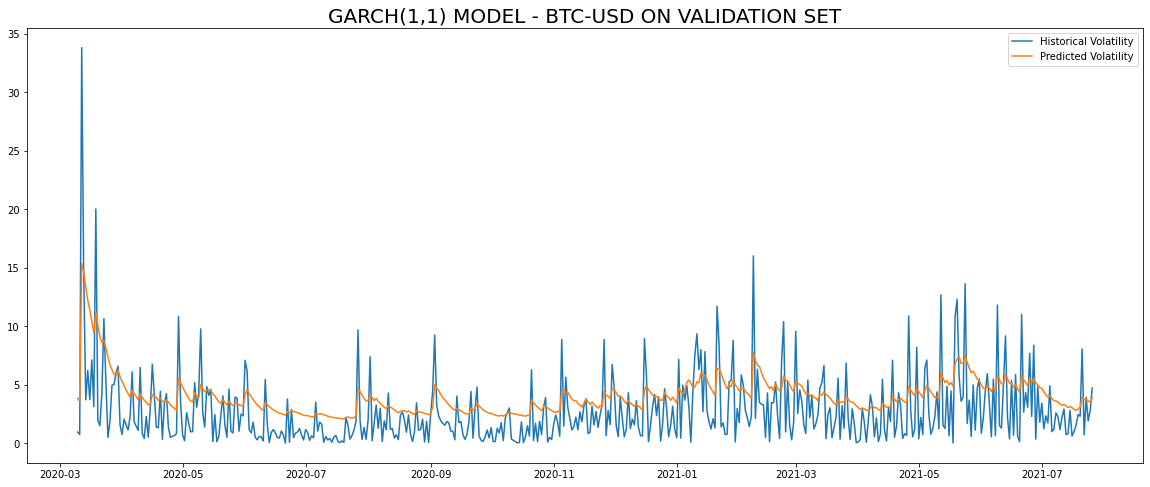

In [91]:
plt.figure(figsize=(20,8))
plt.plot(vol_val, label='Historical Volatility')
plt.plot(rolling_predictions, label='Predicted Volatility')

plt.title(f'GARCH(1,1) MODEL - {tckr} ON VALIDATION SET', fontsize=20)
plt.legend();

In [92]:
RMSE(vol_val, rolling_predictions)

2.7818673662786173

It looks like reducing the `WINDOW_SIZE` might help the predictions get closer to look-back volatility.

In [93]:
WINDOW_SIZE = 7

# CALCULATING VOLATILITY ON A 14 DAY PERIOD
vols = get_volatility(returns, window=WINDOW_SIZE)

vol_train = vols[train_idx]
vol_val = vols[val_idx]
vol_test = vols[test_idx]

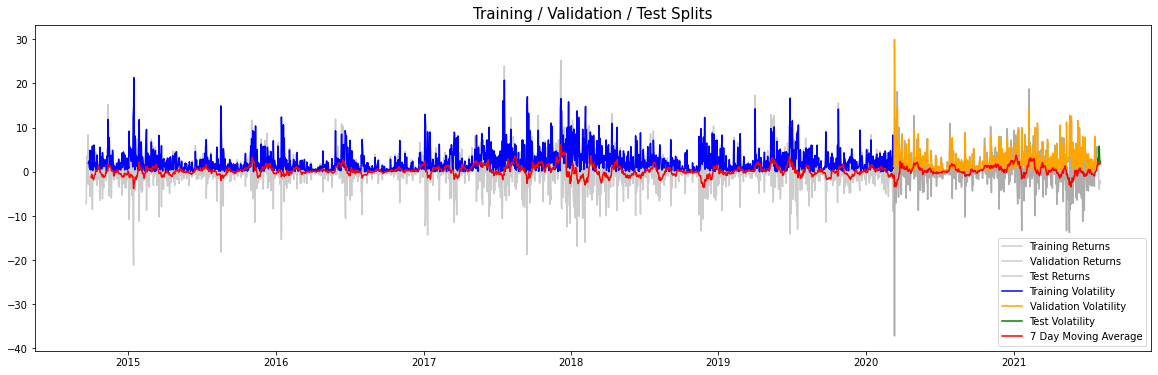

In [94]:
plt.figure(figsize=(20,6))

plt.plot(ts_train, color='gray', label='Training Returns', alpha=0.4)
plt.plot(ts_val, color='gray', label='Validation Returns', alpha=0.4)
plt.plot(ts_test, color='gray', label='Test Returns', alpha=0.4)

plt.plot(vol_train, color='blue', label='Training Volatility')
plt.plot(vol_val, color='orange', label='Validation Volatility')
plt.plot(vol_test, color='green', label='Test Volatility')

plt.plot(ma, color='red', 
         label=f'{WINDOW_SIZE} Day Moving Average')

plt.plot()
plt.title('Training / Validation / Test Splits', fontsize=15)
plt.legend()
plt.show();

In [95]:
gm_1 = arch_model(ts_train, vol='GARCH', p=1, q=1,
                  mean='constant', dist='normal')

In [96]:
gm_1_fit = gm_1.fit()
print(gm_1_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6750.0866136911945
Iteration:      2,   Func. Count:     18,   Neg. LLF: 6739.333283003252
Iteration:      3,   Func. Count:     26,   Neg. LLF: 6736.995241974863
Iteration:      4,   Func. Count:     35,   Neg. LLF: 6736.738873142366
Iteration:      5,   Func. Count:     43,   Neg. LLF: 6734.109631527377
Iteration:      6,   Func. Count:     50,   Neg. LLF: 6733.534200417541
Iteration:      7,   Func. Count:     56,   Neg. LLF: 6733.438698809054
Iteration:      8,   Func. Count:     62,   Neg. LLF: 6733.429424856768
Iteration:      9,   Func. Count:     68,   Neg. LLF: 6733.425260959293
Iteration:     10,   Func. Count:     74,   Neg. LLF: 6733.425254924305
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6733.425254924421
            Iterations: 10
            Function evaluations: 74
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results             

In [97]:
# ROLLING FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    idx = val_idx[i]
    ts_train = returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(ts_train, vol='GARCH', p=1, q=1,
                       mean='constant', dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5
    
    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [98]:
rolling_predictions = pd.Series(rolling_forecasts, index=ts_val.index)

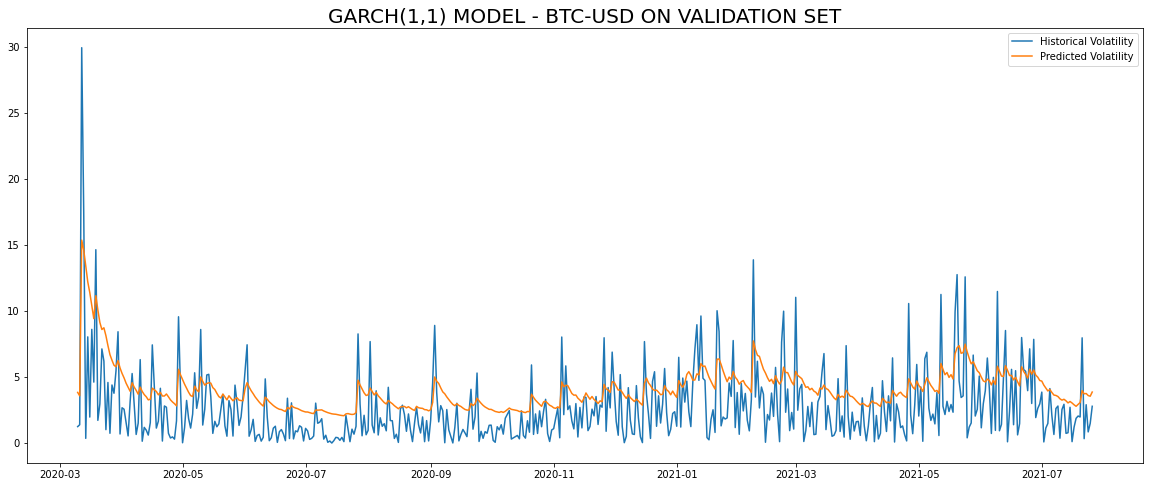

In [99]:
plt.figure(figsize=(20,8))
plt.plot(vol_val, label='Historical Volatility')
plt.plot(rolling_predictions, label='Predicted Volatility')

plt.title(f'GARCH(1,1) MODEL - {tckr} ON VALIDATION SET', fontsize=20)
plt.legend();

In [100]:
RMSE(vol_val, rolling_predictions)

2.6417292069929537

Ref: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html

As seen above, returns are heavy tailed, and Students T distribution tends capture this feature. Therefore, I'll try another version of GARCH using the Student's T distribution to see how the results would look.


In [101]:
gm_1t = arch_model(ts_train, p=1, q=1, dist="StudentsT")
gm_1t_fit = gm_1t.fit(update_freq=5)

Iteration:      5,   Func. Count:     43,   Neg. LLF: 6402.155704268802
Iteration:     10,   Func. Count:     82,   Neg. LLF: 6378.274485982429
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6377.998080650939
            Iterations: 14
            Function evaluations: 112
            Gradient evaluations: 14


In [102]:
print(gm_1t_fit.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6378.00
Distribution:      Standardized Student's t   AIC:                           12766.0
Method:                  Maximum Likelihood   BIC:                           12795.1
                                              No. Observations:                 2500
Date:                      Wed, Aug 04 2021   Df Residuals:                     2499
Time:                              02:45:14   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

In [103]:
rolling_forecasts = []

for i in range(len(ts_val)):
    idx = val_idx[i]
    ts_train = returns[:idx]
    model = arch_model(ts_train, p=1, q=1, dist="StudentsT")
    model_fit = model.fit(disp='off')
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5
    rolling_forecasts.append(pred)

rolling_predictions = pd.Series(rolling_forecasts, index=ts_val.index)

In [104]:
RMSE(vol_val, rolling_predictions)

2.7484903122896793

RMSE is slightly higher than previous model using 'normal' distribution, so I'll stick with it for the next steps.

GARCH(1,1) derives its value based solely on the most recent updates of $\epsilon$ and $\sigma$, which is helpful if the returns series is less "bursty" (meaning price changes are relatively similar). However, this model's weakness emerges when there're more sudden jumps (shocks) in price returns.

Next I'm going to experiment with various values for p & q just to see how the errors would look.

In [105]:
# CREATE A RANGE OF VALUES FOR p & q TO EXPERIMENT WITH
pq_s = range(1,10)
rmse_s = []

for pq in pq_s:
    rolling_forecasts = []

    for i in range(len(ts_val)):
        idx = val_idx[i]
        ts_train = returns[:idx]
        model = arch_model(ts_train, vol='GARCH', p=pq, q=pq,
                        mean='constant', dist='normal')
        model_fit = model.fit(disp='off')
        pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5
        rolling_forecasts.append(pred)

    rolling_predictions = pd.Series(rolling_forecasts, index=ts_val.index)

    s = RMSE(vol_val, rolling_predictions)
    rmse_s.append(s)

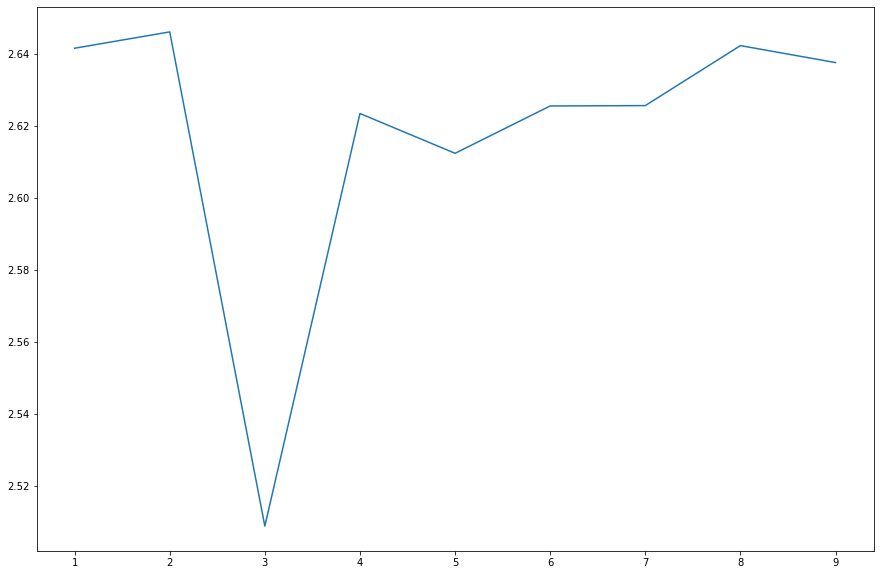

In [106]:
plt.figure(figsize=(15,10))
plt.plot(pq_s, rmse_s)
plt.show();

In [107]:
np.max(rmse_s)

2.6462626466434447

In [108]:
np.min(rmse_s)

2.508922665596942

Within the range of [1,10], p and q = 3 seems to have the lowest loss, although the difference between the highest and lowest values seem relatively small (2.795383493461125 vs. 2.627182875728867).

Therefore I'll train another model using p and q both = 3

In [109]:
gm_3 = arch_model(ts_train, vol='GARCH', p=3, q=3,
                  mean='constant', dist='normal')

In [110]:
gm_3_fit = gm_3.fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 6744.124773946711
Iteration:      2,   Func. Count:     22,   Neg. LLF: 6739.806114109668
Iteration:      3,   Func. Count:     34,   Neg. LLF: 6736.967612582431
Iteration:      4,   Func. Count:     47,   Neg. LLF: 6735.170940247497
Iteration:      5,   Func. Count:     58,   Neg. LLF: 6732.423720151585
Iteration:      6,   Func. Count:     69,   Neg. LLF: 6730.990287857011
Iteration:      7,   Func. Count:     80,   Neg. LLF: 6729.541716484673
Iteration:      8,   Func. Count:     91,   Neg. LLF: 6728.724977372056
Iteration:      9,   Func. Count:    102,   Neg. LLF: 6728.326185816608
Iteration:     10,   Func. Count:    113,   Neg. LLF: 6728.218562285328
Iteration:     11,   Func. Count:    124,   Neg. LLF: 6727.99274605049
Iteration:     12,   Func. Count:    135,   Neg. LLF: 6727.817259596386
Iteration:     13,   Func. Count:    146,   Neg. LLF: 6727.785787722867
Iteration:     14,   Func. Count:    156,   Neg. LLF: 6727.562157

In [111]:
print(gm_3_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6727.51
Distribution:                  Normal   AIC:                           13471.0
Method:            Maximum Likelihood   BIC:                           13517.6
                                        No. Observations:                 2500
Date:                Wed, Aug 04 2021   Df Residuals:                     2499
Time:                        03:09:03   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2247  6.011e-02      3.738  1.856e-04 [  0.107,  0.34

In [112]:
# ROLLING FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    idx = val_idx[i]
    ts_train = returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(ts_train, vol='GARCH', p=3, q=3,
                       mean='constant', dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5
    
    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [113]:
gm_3_rolling_preds = pd.Series(rolling_forecasts, index=ts_val.index)

In [114]:
RMSE(vol_val, gm_3_rolling_preds)

2.508922665596942

### Single Layer NN

(basically Linear Regression)

In [131]:
import tensorflow as tf

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
from keras import backend as K

In [ ]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = K.sqrt(K.mean(K.square(((y_true - y_pred) / y_true))))

    return loss

In [ ]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss='mse',
              optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=[rmspe])

model.fit(dataset, epochs=300, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
forecast = []
idx = returns.index

for t in range(len(x_val)):
    forecast.append(model.predict(returns[idx[t]:idx[t+window_size-1]].values[np.newaxis]))
    
forecast = forecast[-len(x_val):]

results = np.array(forecast)[:, 0, 0]

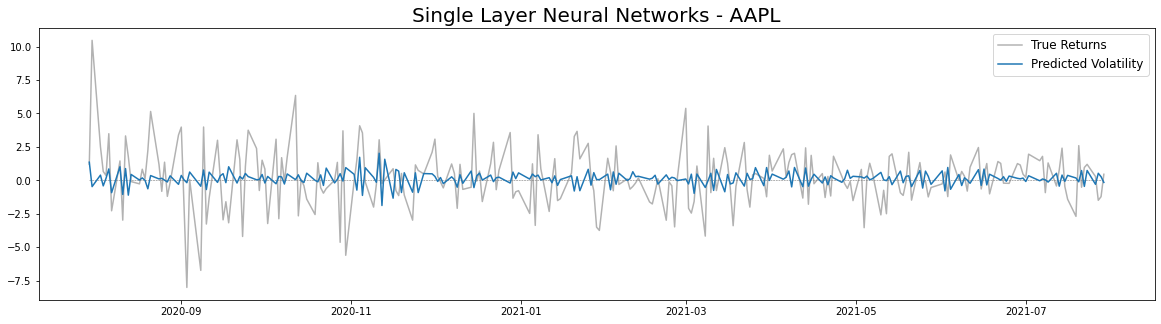

In [ ]:
plt.figure(figsize=(20,5))
true, = plt.plot(x_val, color='gray', alpha=0.6)
preds, = plt.plot(pd.Series(results, index=x_val.index))
# abs_true, = plt.plot(np.abs(x_val))
plt.hlines(y=0, 
           xmin=x_val.index[0],
           xmax=x_val.index[-1],
           color='black', alpha=0.6, ls='--', lw=0.5)
plt.title(f'Single Layer Neural Networks - {tckr}', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=12, loc='best');

In [ ]:
RMSPE(x_val, results)

4.8486218022390375

### Deep Neural Network

#### Find the best learning rate by adjusting it during training

In [ ]:
# INCREASE WINDOW SIZE TO 30
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

# USE callbacks TO SCHEDULE LEARNING RATE CHANGES
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * (10**(epoch/20)))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# COMPILE MODEL
model.compile(loss='mse', optimizer=optimizer, metrics=[rmspe])

# FIT MODEL TO DATA
history = model.fit(dataset, epochs=160, 
                    callbacks=[lr_scheduler])

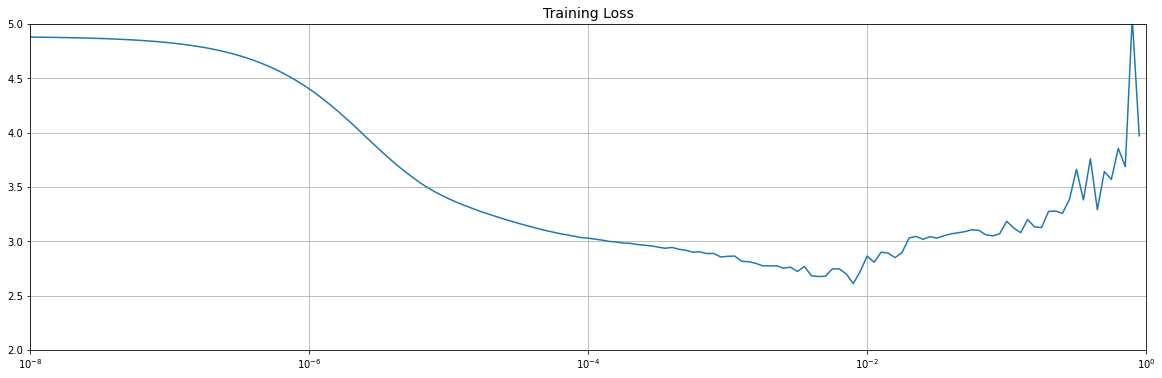

In [ ]:
lrs = 1e-8 * (10**(np.arange(160)/20))
fig, ax = plt.subplots(figsize=(20,6))
ax.semilogx(lrs, history.history['loss'])
ax.grid(True, which='both')
ax.axis([1e-8, 1, 2, 5])
ax.set_title('Training Loss', fontsize=14)
plt.show();

It appears that the best learning rate where it looks like Loss hits its minimum while it's still relatively stable is around 1 notch away from 1e-2.

So I'm going to pick `8e-3`.

In [ ]:
best_lr = 8e-3

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=best_lr, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer, metrics=[rmspe])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('dnn_1.h5',
                                                   save_best_only=True,
                                                   monitor='loss',
                                                   mode='min')
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
#                                                      restore_best_weights=True,
#                                                      monitor='loss',
#                                                      mode='min')


history = model.fit(dataset, epochs=500,
                    callbacks=[checkpoint_cb],
                    verbose=1)

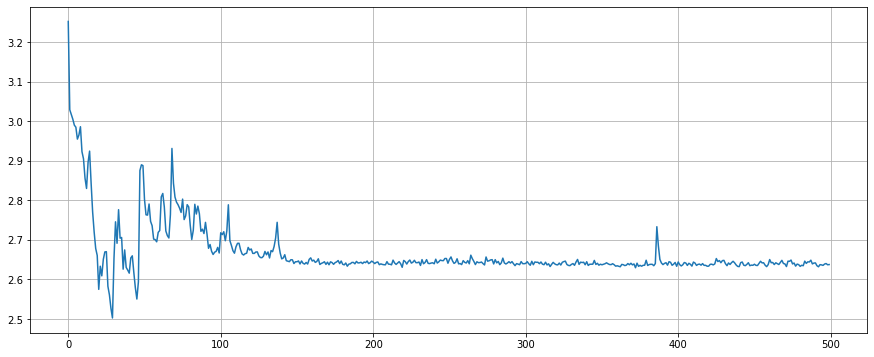

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.figure(figsize=(15,6))
plt.plot(epochs, loss, label='Training Loss')
plt.grid()
plt.show();

In [ ]:
forecast = []
idx = returns.index

for t in range(len(x_val)):
    forecast.append(model.predict(returns[idx[t]:idx[t+window_size-1]].values[np.newaxis]))
    
forecast = forecast[-len(x_val):]

results = np.array(forecast)[:, 0, 0]

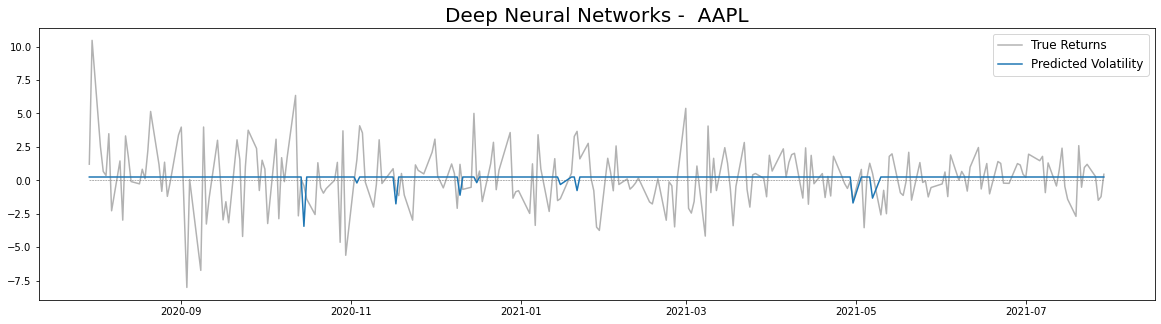

In [ ]:
plt.figure(figsize=(20,5))
true, = plt.plot(x_val, color='gray', alpha=0.6)
preds, = plt.plot(pd.Series(results, index=x_val.index))
# abs_true, = plt.plot(np.abs(x_val))
plt.hlines(y=0, 
           xmin=x_val.index[0],
           xmax=x_val.index[-1],
           color='black', alpha=0.6, ls='--', lw=0.5)
plt.title(f'Deep Neural Networks -  {tckr}', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=12, loc='best');

In [ ]:
RMSPE(x_val, results)

3.012296629726072

### Recurrent Neural Networks

#### Simple RNN

In [ ]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
rnn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.SimpleRNN(20),
    tf.keras.layers.Dense(1)
])

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * (10**(epoch/20)))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
rnn_1.compile(loss='mse', optimizer=optimizer)
history = rnn_1.fit(dataset, epochs=160,
                    callbacks=[lr_scheduler])

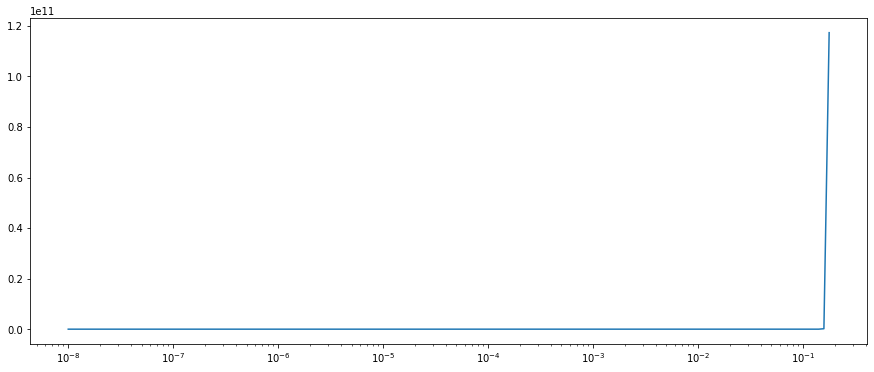

In [ ]:
# plotting learning rate & loss
plt.figure(figsize=(15,6))
plt.semilogx(history.history['lr'], history.history['loss'])
plt.show();

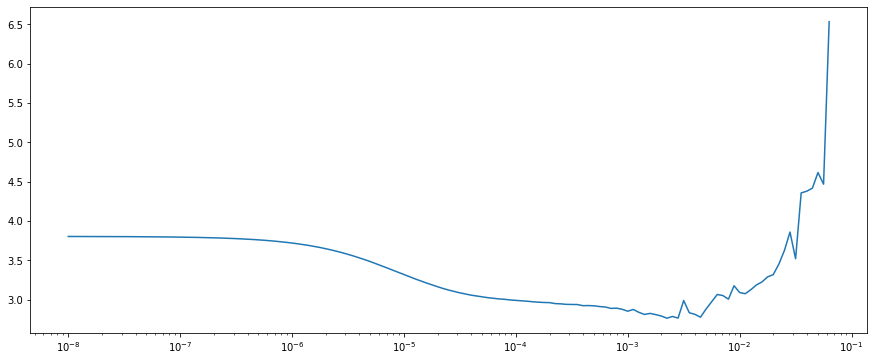

In [ ]:
# plotting learning rate & loss
plt.figure(figsize=(15,6))
plt.semilogx(history.history['lr'][:137], history.history['loss'][:137])
plt.show();

In [ ]:
history.history['lr'][109]

0.002818383

In [ ]:
history.history['loss'][109]

2.7656197547912598

In [ ]:
best_lr = history.history['lr'][109]

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(2021)
np.random.seed(2021)

rnn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.SimpleRNN(20),
    tf.keras.layers.Dense(1)
])

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('rnn_1.h5',
                                                   save_best_only=True,
                                                   monitor='loss',
                                                   mode='min')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True,
                                                     monitor='loss',
                                                     mode='min')

optimizer = tf.keras.optimizers.SGD(lr=best_lr, momentum=0.9)
rnn_1.compile(loss='mse', optimizer=optimizer)
rnn_1_hist = rnn_1.fit(dataset, epochs=500, callbacks=[checkpoint_cb, early_stopping_cb])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
83/83 [==============================] - 2s 12ms/step - loss: 3.1193
Epoch 2/500
83/83 [==============================] - 1s 12ms/step - loss: 3.0167
Epoch 3/500
83/83 [==============================] - 1s 12ms/step - loss: 2.9905
Epoch 4/500
83/83 [==============================] - 1s 12ms/step - loss: 2.9809
Epoch 5/500
83/83 [==============================] - 1s 12ms/step - loss: 2.9536
Epoch 6/500
83/83 [==============================] - 1s 12ms/step - loss: 2.9452
Epoch 7/500
83/83 [==============================] - 1s 12ms/step - loss: 2.8951
Epoch 8/500
83/83 [==============================] - 1s 12ms/step - loss: 2.8820
Epoch 9/500
83/83 [==============================] - 1s 12ms/step - loss: 2.8509
Epoch 10/500
83/83 [==============================] - 1s 12ms/step - loss: 2.8814
Epoch 11/500
83/83 [==============================] - 1s 12ms/step - loss: 2.8801
Epoch 12/500
83/83 [==============================] - 1s 12ms/step - loss: 2.8086
Epoch 13/500
83/83 [=====

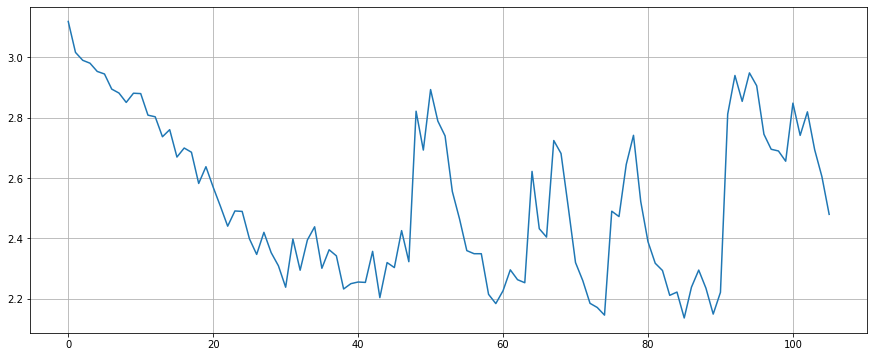

In [ ]:
loss = rnn_1_hist.history['loss']
epochs = range(len(loss))
plt.figure(figsize=(15,6))
plt.plot(epochs, loss, label='Training Loss')
plt.grid()
plt.show();

In [ ]:
forecast = []
idx = returns.index

for t in range(len(x_val)):
    forecast.append(rnn_1.predict(returns[idx[t]:idx[t+window_size-1]].values[np.newaxis]))
    
forecast = forecast[-len(x_val):]

results = np.array(forecast)[:, 0, 0]

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

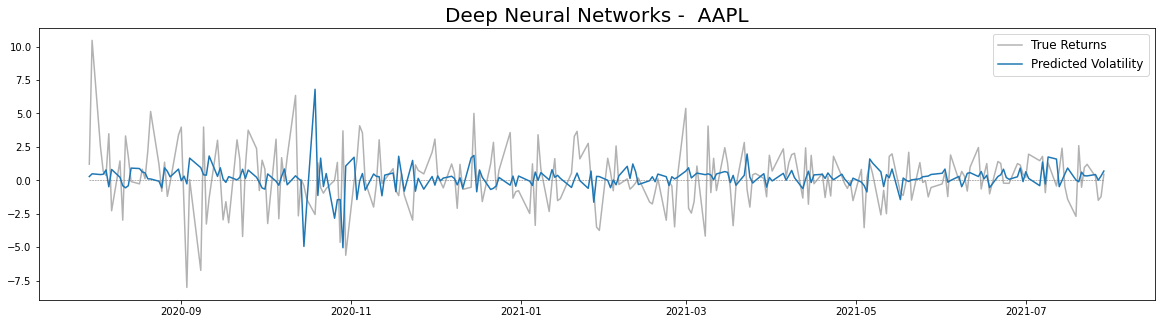

In [ ]:
plt.figure(figsize=(20,5))
true, = plt.plot(x_val, color='gray', alpha=0.6)
preds, = plt.plot(pd.Series(results, index=x_val.index))
plt.hlines(y=0, 
           xmin=x_val.index[0],
           xmax=x_val.index[-1],
           color='black', alpha=0.6, ls='--', lw=0.5)
plt.title(f'Deep Neural Networks -  {tckr}', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=12, loc='best');

In [ ]:
RMSPE(x_val, results)

20.957791885718436